# Gromore basic domain
## Model Description before GroMore proposal 
This is a steady state box model with recharge and ET. An additional layer was also added to the model.

#### Dimensions: 
- 50 by 50 by 1
- dx = dy = 1000 m
- dz = varied 
- three layers

#### Topography
- Top layer elevation given in csv file
- Middle layer is flat and 5m thick
- Bottom layer (Layer 3) is flat and 40m thick

#### Subsurface Properties: 
- Porosity = 0.1
- Specific yield = 0.1
- Storage coefficient=0.0001 
- Homogeneous in each layer
##### Layers
 - Layer 1 = Layer 3
     - Kx=Ky=Kz= 10m/d
 - Layer 2 
     - 20 leftmost columns, Kx=Ky=Kz= 10m/d
     - Other columns, Kz= 0.0001m/d

#### Boundary Conditions: 
 - Right boundary is a constant head of 70 m relative to datum for all layers (datum is at bottom of domain)
 - All other boundaries are no flow
 - Top left corner: no flow
     - Extends from row 45, column 1 to row 50, column 6, inclusive, comprising a total of 21 no flow cells
 - A symmetric no flow region exists in the bottom left corner
     - row 41, column 1 to row 50, column 10.
 - Middle layer has no flow regions
     - Extends from row 43, column 1 to row 50, column 8 
 
#### ET: 
- Zero in left half
- 1E-5 m/day in the right half of the domain
- Riparian zone
    - Extends from left to right boundary of rows 23 to 29, inclusive
    - Rate: 5E-5m/d
- Extinction depth= 10m
 
#### Recharge: 
 - Leftmost 15 columns at a rate of 4E-5 m/d
 - Zero everywhere else

#### Stream:
- Begins in left boundary and goes to the right in row 26
- width=length=thickness= 1.0
- No flow is entering the stream
- streambed
    - K= 1000m/d
    - elevation= 1.0m below ground surface
    - stage= 0.5m
- "weak sink" with strength 0.5 (This is set under MODPATH/Particle Options.)
 
#### Well: 
 - Pumping well for Aquaseca
     - Completed in bottom layer
     - Located at row 21, column 38
     - Pumping at a rate of 1500 m^3/day 

## Model Description after GroMore proposal 

#### Ag field:
- cover a 2000m by 2000m area
- 1/8th of the area will be irrigated agriculture at any time (the field area is multiplied by 0.125). 
- Rectangular irrigated fields extend between rows 21 and 22 (inclusive) and columns 19 and 20 (inclusive).

##### ET
- ET for the crop is zero - it is accounted for in the calculated recharge 

##### Recharge
- Rate is 20% of the water demand of the crop, representing intentional excess irrigation to avoid soil salinization
- Crop water uses/recharge rates:
    - Wheat= 0.004m/d / 0.0001m/d
    - Pistachios= 0.006m/d / 0.00015m/d
    - Cotton: 0.008 m/d / 0.0002 m/d
    
##### Pumping Well:
- Completed in top layer
- Row 12 and column 14
- Pumping rate equal to the crop water demand plus 20% for excess irrigation plus 30% for irrigation inefficiency
    - Wheat= 3000 m3/day
    - Pistachos= 4500 m3/d
    - Cotton= 6000 m3/d
    
##### Monitoring wells
- Two monitoring in transient conditions
    - One at [25000, 25000] 
    - Other at [12500, 12500].

*For simplicity, we will consider a year to be comprised of 12 30-day months.

## 1. Import packages

In [83]:
#import packages
import flopy
import numpy as np
import matplotlib as mp
import os
import flopy.utils.binaryfile as bf
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import csv
from numpy import asarray
from numpy import savetxt

#print full output
np.set_printoptions(threshold=np.inf)

#jupyter specific--included to show plots in notebook
%matplotlib inline 

#Delete Packages
# dir = "/Users/amanda_triplett/Documents/Courses/groundwater_Modeling/GroMore_Project/amanda/scenario2"
# dir = "C:\Users\vivek\Documents\UA Coursework\HWRS 582 Groundwater Modelling\GroMore_Project\Vivek\Scenario 1"
# dir = "/Users/hardknox47/Desktop/HWRS482/hw482/GroMore_Project/Justin"

# files = os.listdir(dir)
# ext=['.dis','.bas','.lpf','.oc','.pcg','.wel','.hds','.cbc','.riv','.list','.nam','.evt',
#      '.rch','.mpbas','.mpend','.mplst','.mpnam','.mppth','.mpsim','.log','.timeseries',
#      '.lis','.chd','.ddn','.sloc']
# for file in files:
#     for i in range(0,len(ext)):
#         if file.endswith(ext[i]):
#             os.remove(os.path.join(dir,file))

# Scenario 5: Post agriculture model with seasonality - future projection
Add the proposed agricultural element (pumping and localized recharge) for growing pistachios to your post-development model with seasonality. Agriculture starts now, 100 years after the end of the burn-in. Both pumping and recharge related to agriculture occur at the rates described and are continuous throughout the year.

## 2. Discretization and other inputs

In [84]:
# Discretization
nrow = 50 #number of rows
ncol = 50 #number of columns
nlay = 3  #number of layers

dx= 1000 #width of grid cells in x direction 
dy= 1000 #width of grid cells in y direction 
Lx = ncol*dx  #width of domain in x
Ly = nrow*dy #width of domain in y

ztop = np.genfromtxt('base_model_elevs.csv', delimiter=',', dtype=float)   # top elevation of top layer (import from csv file) (dim: nrow,ncol)

## Subsurface properties
n = 0.1        #assign porosity
Ss = 0.0001      #assign storage coefficient
Sy = 0.1        #assign specific yield
uncnf = 1       #0=confined, >0 = unconfined

## ET
ET = 1e-5 #m/day
ET_locxy=[[24000,0], [0, 0]] #lower left and upper right corners of ET in xy coordinate
ET_rows_forced=(1.0, 49.0) #me forcing the et_rows to be 0-50
ET_cols_forced = (26.0, 49.0)
ET_zone = np.zeros((1,nrow,ncol))     # define an array of zeroes the size of the model grid
ET_zone[0,int(ET_rows_forced[0]):int(ET_rows_forced[1]), 
        int(ET_cols_forced[0]):int(ET_cols_forced[1])] = ET 

rip_ET= 5e-5  #riparian zone
rip_locxy= [[0,21000],[23000,0]]
rip_rows_forced = (21.0, 28.0)  #forced riparian area
rip_cols_forced = (1.0, 49.0)
rip_zone = np.zeros((nlay,nrow,ncol))     # define an array of zeroes the size of the model grid
ET_zone[0,int(rip_rows_forced[0]):int(rip_rows_forced[1]), 
        int(rip_cols_forced[0]):int(rip_cols_forced[1])] = rip_ET 

extinction_depth = 10 #m

## Recharge
rech=4e-5  #m/d
rechag=0.00015*0.125  # (0.0001, 0.00015, 0.0002) m/day (wheat, pistachios, cotton)

rechxy=[(0,0),(0,36000)]  #recharge zone

rechag_rows=(28,29)
rechag_cols=(18,19)

rech_rows_forced = (1.0, 49.0) #rech zone forced for leftmost 15 cols
rech_cols_forced = (1.0, 15.0)

rech_zone = np.zeros((1,nrow,ncol))
rech_zone[0,int(rech_rows_forced[0]):int(rech_rows_forced[1]),
          int(rech_cols_forced[0]):int(rech_cols_forced[1])]=rech
rech_zone[0,int(rechag_rows[0]):int(rechag_rows[1]),
          int(rechag_cols[0]):int(rechag_cols[1])]=rechag
#print("recharge location forced(col, row)", rech_cols_forced,rech_rows_forced)

# Setting up wells
pumping1 = 0 # m3/day      -1500 pumping rate for water supply well  
pumping2 = -4500*0.125 # m^3/d   (-3000,-4500,-6000) irrigation well pumping rate (wheat, pistachios, cotton)

well_agua = [2,29,37, pumping1] #Well loc (layer, row, column)
well_ag = [0,38,12, pumping2] #Well loc (layer, row, column)
MW1 = [0,25,24,0]
MW2 = [0,37,12,0]

wel_spd = {0: [well_agua, well_ag, MW1, MW2]}

## init boundary conditions
h_right = 70

In [85]:
# savetxt('rech_zone.csv', rech_zone[0], delimiter=',')

### Layering

In [86]:
## define layer properties 
K_horiz = 10 #m/d
K_vert = 10 #m/d
K_vert2 = 0.0001 #m/d  #K for the middle layer 

## make horizontal K np arrays
Kh = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kh[:,:,:] = K_horiz # assign the original value to the entire array

## Make a arrays for the K values
Kz = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kz[:,:,:] = K_vert                   # assign the original value to the entire array
Kz[1,:,20:49] = K_vert2            #Replace K in the middle layer with the lower value

## Make some changes to the parameters
bot_elev = 0.
mid_elev = 40.
top_elev = 45.

botm = np.zeros((nlay,nrow,ncol)) # initialize array of zeros for bottom elevation for each model cell (dim: nlay,nrow,ncol)
botm[2,:,:] = bot_elev                 # bottom elevation of lowest layer (2) is 0 m
botm[1,:,:] = mid_elev                 #bottom elevation of middle layer (1) is 40 m           
botm[0,:,:] = top_elev                 # bottom elevation of top layer (0) 45 

## Boundary Conditions

In [87]:
#setup initial heads as the end of scenario 2 burn in values (after 200 years w. seasonality)

H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
H_init[0, :, :] = np.genfromtxt('top_head_postdevel_100yr.csv', delimiter=',', dtype=float)  #initialize the top layer with 200 yr burn in vals
H_init[1, :, :] = np.genfromtxt('mid_head_postdevel_100yr.csv', delimiter=',', dtype=float)  #initialize the mid layer with 200 yr burn in vals
H_init[2, :, :] = np.genfromtxt('bot_head_postdevel_100yr.csv', delimiter=',', dtype=float)  #initialize the bottom layer with 200 yr burn in vals

#Adding no flow boundaries
#########################

# Define cell activity (IBOUND)
ibound=np.ones((nlay,nrow,ncol))                                                  
ibound[:,:,0] = 0  # 1st col = no flow       
ibound[:,:,49] = -1  # last col = constant head 

ibound[:,0,:49]=0
ibound[:,49,:49]=0
ibound[:,1,:5]=0
ibound[:,2,:4]=0
ibound[:,3,:3]=0
ibound[:,4,:2]=0

ibound[:,48,:5]=0
ibound[:,47,:4]=0
ibound[:,46,:3]=0
ibound[:,45,:2]=0

ibound[1:,1,:7]=0
ibound[1:,2,:6]=0
ibound[1:,3,:5]=0
ibound[1:,4,:4]=0
ibound[1:,5,:3]=0
ibound[1:,6,1]=0

ibound[1:,48,:7]=0
ibound[1:,47,:6]=0
ibound[1:,46,:5]=0
ibound[1:,45,:4]=0
ibound[1:,44,:3]=0
ibound[1:,43,1]=0

ibound[2,1,:9]=0
ibound[2,2,:8]=0
ibound[2,3,:7]=0
ibound[2,4,:6]=0
ibound[2,5,:5]=0
ibound[2,6,:4]=0
ibound[2,7,:3]=0
ibound[2,8,1]=0

ibound[2,48,:9]=0
ibound[2,47,:8]=0
ibound[2,46,:7]=0
ibound[2,45,:6]=0
ibound[2,44,:5]=0
ibound[2,43,:4]=0
ibound[2,42,:3]=0
ibound[2,41,1]=0

## River Properties

In [88]:
#DEFINE RIVERS
riv_row= 24
riv_sp = [] #create list to store all river cells for stress period 1
k_rivbott = 1000 #river bottom hydraulic conductivity in m/d
sed_thick = 1 #thickness of riverbed sediment in m
cond = k_rivbott*(1)*(1000)/(sed_thick) #river bed conductance in m^2/d
r_stage = .5 #stage in river (stress period 1)
r_bott = ztop[riv_row,:] #river bottom
#print(r_bott)
for i in range(1,ncol):
    riv_sp.append([0, riv_row, i, r_bott[i]-1+sed_thick+r_stage, cond, r_bott[i]-2])
    
#create dictionary of stress period data
riv_spd = {0: riv_sp}

### Setting up seasonality


In [89]:
#We start in October, because that's a water year
sp_peryr = 2        # periods for seasonality (two stress periods per year)
sp1_len = 180       # Length of stress period 1 in days, October-March, no ET
sp2_len = 180      # Length of stress period 2 in days. April - September, regular ET
sim_years = 100       #number of years for transient simulation 
#nper = int(sp_peryr*sim_years + 1) # 201
nper = int(sp_peryr*sim_years)

#setup the steady state array
steady = np.ones(nper, dtype=bool)*False # transient flag is false
#steady[0] = True    # initial stress period is steady-state or true

#make an array of period lengths
perlen=np.tile([sp1_len, sp2_len],sim_years)#100 repeating sets of the two stress periods
#perlen=np.append(10,perlen) #add a period of length 10 at the start for the steady state simulation

#make an nstp array for the # of time steps to solve within each period in this case we will do daily 
#so we can repeat the perlen array
nstp=perlen*1  
#nstp[0]=1 #for the steady state solution we just want one output

### Setting up seasonal ET

In [90]:
#Setup alternating ET values
#ET_zone has the seasonal ET values
                      
ET_dict = {} #set up an ET dictionary, where each key is a stress period num 0-50
ET_zone2 = ET_zone * 0 
for p in range(0,nper):    #loop over stress periods, odds are 0 ET, evens are reg ET
    if p == 0:
        ET_dict[p] = ET_zone
    elif int(p % 2) != 0:
        ET_dict[p]=ET_zone2
        #print(p)
    else: 
        ET_dict[p] = ET_zone

## Setting up the post development pumping

In [91]:
#addings these pumping wells for aguaseca community well
t=np.arange(0,210,10)
# print(t)
pumping_spd={}
for a in range(0,len(t)):
    pumping_spd[a]=[2,29,37,-round(1.5*(t[a])**(1.5))]
# print(pumping_spd)

#Set up the wel data for stress periods, changing well_agua pumping rate
wel_spd = {}  

i=11

for p in range(0,201): #nper = 201
    if (199>p>0 and ((p) % 20) == 0):
        i=i+1
    if (p >= 0 and p <= 21):
        wel_spd[p]=[pumping_spd[i], well_ag, MW1, MW2]
    elif (p <= 41):
        wel_spd[p]=[pumping_spd[i], well_ag, MW1, MW2]
    elif (p <= 61):
        wel_spd[p]=[pumping_spd[i], well_ag, MW1, MW2]
    elif (p<= 81):
        wel_spd[p]=[pumping_spd[i], well_ag, MW1, MW2]
    elif (p <= 101):
        wel_spd[p]=[pumping_spd[i], well_ag, MW1, MW2]
    elif (p <= 121):
        wel_spd[p]=[pumping_spd[i], well_ag, MW1, MW2]
    elif (p <= 141):
        wel_spd[p]=[pumping_spd[i], well_ag, MW1, MW2]
    elif (p <= 161):
        wel_spd[p]=[pumping_spd[i], well_ag, MW1, MW2]
    elif (p <= 181):
        wel_spd[p]=[pumping_spd[i], well_ag, MW1, MW2]
    elif (p <= 201):
        wel_spd[p]=[pumping_spd[i], well_ag, MW1, MW2]
    else:
        print('p not in range')

## Set up and run scenario 5

In [92]:
#Initialize the model
modelname = "Scenario_5"
moddir="/Users/hardknox47/Desktop/HWRS482/MODFLOW/pymake/examples/mf2005"
# moddir="/Users/amanda_triplett/Documents/Courses/groundwater_Modeling/pymake/examples/mf2005"
m = flopy.modflow.Modflow(modelname, exe_name = moddir)

#Discretization - dis
dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=botm, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady, perlen=perlen, nstp = nstp)

# Boundary and initial conditions - bas
bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=H_init)

#Layer properties - lpf
lpf = flopy.modflow.ModflowLpf(m, laytyp=1, hk=Kh, 
                               vka=Kz, ss=Ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53)

#create rch object
rch = flopy.modflow.mfrch.ModflowRch(model=m, rech=rech_zone, ipakcb=53)     


# Attach ET package
evt = flopy.modflow.mfevt.ModflowEvt(m, surf=ztop, evtr=ET_dict, exdp=extinction_depth, ipakcb=53) 

wel = flopy.modflow.ModflowWel(model=m, stress_period_data=wel_spd)

#Setting up RIV package
riv = flopy.modflow.ModflowRiv(model=m,stress_period_data = riv_spd, ipakcb=53)

#Output control - OC 
oc_spd = {}
for kper in range(1,nper): #nper is 201, this is the key for each entry in oc_spd dict
    oc_spd[(kper, 1)] = ['save head','save drawdown','save budget','print head','print budget']
    oc_spd[(kper, 90)] = ['save head','save drawdown','save budget','print head','print budget']
    oc_spd[(kper, 179)] = ['save head','save drawdown','save budget','print head','print budget']
oc = flopy.modflow.ModflowOc(model=m, stress_period_data=oc_spd, compact=True)

#Numerical solver - pcg
# pcg = flopy.modflow.ModflowPcg(model=m)
#Numerical solver - pcg
pcg = flopy.modflow.ModflowPcg(model=m, mxiter=100, iter1=200, relax = 0.97, damp = 0.9)

#write the inputs
m.write_input()   

m.evt.check()
m.oc.check()
m.oc.check()
m.lpf.check()
m.pcg.check()
m.riv.check()
m.rch.check()
m.dis.check()

check method not implemented for EVT Package.

OC PACKAGE DATA VALIDATION:
  No errors or warnings encountered.


OC PACKAGE DATA VALIDATION:
  No errors or warnings encountered.


LPF PACKAGE DATA VALIDATION:
  1 Warning:
    STORAGECOEFFICIENT option is activated, storage values are read storage coefficients

  Checks that passed:
    zero or negative horizontal hydraulic conductivity values
    zero or negative vertical hydraulic conductivity values
    negative horizontal anisotropy values
    horizontal hydraulic conductivity values below checker threshold of 1e-11
    horizontal hydraulic conductivity values above checker threshold of 100000.0
    vertical hydraulic conductivity values below checker threshold of 1e-11
    vertical hydraulic conductivity values above checker threshold of 100000.0
    zero or negative specific storage values
    specific storage values below checker threshold of 1e-06
    specific storage values above checker threshold of 0.01
    zero or negative 

In [93]:
#Run the model 
success, mfoutput = m.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

FloPy is using the following  executable to run the model: /Users/hardknox47/Desktop/HWRS482/MODFLOW/pymake/examples/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: Scenario_5.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2020/04/27 17:08:47

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress 

 Solving:  Stress period:     1    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   113    Ground-Wa

 Solving:  Stress period:     2    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    40    Ground-Wa

 Solving:  Stress period:     2    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:   156    Ground-Wa

 Solving:  Stress period:     3    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    92    Ground-Wa

 Solving:  Stress period:     4    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    21    Ground-Wa

 Solving:  Stress period:     4    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:   130    Ground-Wa

 Solving:  Stress period:     5    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    57    Ground-Wa

 Solving:  Stress period:     5    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:   175    Ground-Wa

 Solving:  Stress period:     6    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:   114    Ground-Wa

 Solving:  Stress period:     7    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    49    Ground-Wa

 Solving:  Stress period:     7    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:   168    Ground-Wa

 Solving:  Stress period:     8    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   109    Ground-Wa

 Solving:  Stress period:     9    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    44    Ground-Wa

 Solving:  Stress period:     9    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   160    Ground-Wa

 Solving:  Stress period:    10    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    88    Ground-Wa

 Solving:  Stress period:    11    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    17    Ground-Wa

 Solving:  Stress period:    11    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:   126    Ground-Wa

 Solving:  Stress period:    12    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    58    Ground-Wa

 Solving:  Stress period:    12    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:   174    Ground-Wa

 Solving:  Stress period:    13    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:   112    Ground-Wa

 Solving:  Stress period:    14    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    43    Ground-Wa

 Solving:  Stress period:    14    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   154    Ground-Wa

 Solving:  Stress period:    15    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    84    Ground-Wa

 Solving:  Stress period:    16    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    20    Ground-Wa

 Solving:  Stress period:    16    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:   142    Ground-Wa

 Solving:  Stress period:    17    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    74    Ground-Wa

 Solving:  Stress period:    18    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    14    Ground-Wa

 Solving:  Stress period:    18    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:   136    Ground-Wa

 Solving:  Stress period:    19    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    68    Ground-Wa

 Solving:  Stress period:    19    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:     8    Ground-Wa

 Solving:  Stress period:    20    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   128    Ground-Wa

 Solving:  Stress period:    21    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    60    Ground-Wa

 Solving:  Stress period:    21    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   180    Ground-Wa

 Solving:  Stress period:    22    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:   117    Ground-Wa

 Solving:  Stress period:    23    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    50    Ground-Wa

 Solving:  Stress period:    23    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   169    Ground-Wa

 Solving:  Stress period:    24    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    95    Ground-Wa

 Solving:  Stress period:    25    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    29    Ground-Wa

 Solving:  Stress period:    25    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   142    Ground-Wa

 Solving:  Stress period:    26    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    73    Ground-Wa

 Solving:  Stress period:    27    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    14    Ground-Wa

 Solving:  Stress period:    27    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:   122    Ground-Wa

 Solving:  Stress period:    28    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    56    Ground-Wa

 Solving:  Stress period:    28    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:   171    Ground-Wa

 Solving:  Stress period:    29    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    97    Ground-Wa

 Solving:  Stress period:    30    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    29    Ground-Wa

 Solving:  Stress period:    30    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:   149    Ground-Wa

 Solving:  Stress period:    31    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    76    Ground-Wa

 Solving:  Stress period:    32    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    14    Ground-Wa

 Solving:  Stress period:    32    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:   134    Ground-Wa

 Solving:  Stress period:    33    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    65    Ground-Wa

 Solving:  Stress period:    33    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:     2    Ground-Wa

 Solving:  Stress period:    34    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:   121    Ground-Wa

 Solving:  Stress period:    35    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:    55    Ground-Wa

 Solving:  Stress period:    35    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   176    Ground-Wa

 Solving:  Stress period:    36    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:   102    Ground-Wa

 Solving:  Stress period:    37    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    36    Ground-Wa

 Solving:  Stress period:    37    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   151    Ground-Wa

 Solving:  Stress period:    38    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    81    Ground-Wa

 Solving:  Stress period:    39    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:    15    Ground-Wa

 Solving:  Stress period:    39    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   123    Ground-Wa

 Solving:  Stress period:    40    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    53    Ground-Wa

 Solving:  Stress period:    40    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:   169    Ground-Wa

 Solving:  Stress period:    41    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:   108    Ground-Wa

 Solving:  Stress period:    42    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:    36    Ground-Wa

 Solving:  Stress period:    42    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   155    Ground-Wa

 Solving:  Stress period:    43    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    93    Ground-Wa

 Solving:  Stress period:    44    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    30    Ground-Wa

 Solving:  Stress period:    44    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:   141    Ground-Wa

 Solving:  Stress period:    45    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    73    Ground-Wa

 Solving:  Stress period:    46    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    15    Ground-Wa

 Solving:  Stress period:    46    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:   121    Ground-Wa

 Solving:  Stress period:    47    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    57    Ground-Wa

 Solving:  Stress period:    47    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:   174    Ground-Wa

 Solving:  Stress period:    48    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:   114    Ground-Wa

 Solving:  Stress period:    49    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    48    Ground-Wa

 Solving:  Stress period:    49    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:   164    Ground-Wa

 Solving:  Stress period:    50    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    91    Ground-Wa

 Solving:  Stress period:    51    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    29    Ground-Wa

 Solving:  Stress period:    51    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   137    Ground-Wa

 Solving:  Stress period:    52    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    63    Ground-Wa

 Solving:  Stress period:    52    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:   179    Ground-Wa

 Solving:  Stress period:    53    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:   109    Ground-Wa

 Solving:  Stress period:    54    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:    42    Ground-Wa

 Solving:  Stress period:    54    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:   150    Ground-Wa

 Solving:  Stress period:    55    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:    89    Ground-Wa

 Solving:  Stress period:    56    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:    23    Ground-Wa

 Solving:  Stress period:    56    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:   144    Ground-Wa

 Solving:  Stress period:    57    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:    72    Ground-Wa

 Solving:  Stress period:    57    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:     8    Ground-Wa

 Solving:  Stress period:    58    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:   123    Ground-Wa

 Solving:  Stress period:    59    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:    52    Ground-Wa

 Solving:  Stress period:    59    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:   162    Ground-Wa

 Solving:  Stress period:    60    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:   102    Ground-Wa

 Solving:  Stress period:    61    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:    39    Ground-Wa

 Solving:  Stress period:    61    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:   156    Ground-Wa

 Solving:  Stress period:    62    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    87    Ground-Wa

 Solving:  Stress period:    63    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:    14    Ground-Wa

 Solving:  Stress period:    63    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:   125    Ground-Wa

 Solving:  Stress period:    64    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:    58    Ground-Wa

 Solving:  Stress period:    64    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:   179    Ground-Wa

 Solving:  Stress period:    65    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:   108    Ground-Wa

 Solving:  Stress period:    66    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:    46    Ground-Wa

 Solving:  Stress period:    66    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:   156    Ground-Wa

 Solving:  Stress period:    67    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:    97    Ground-Wa

 Solving:  Stress period:    68    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:    35    Ground-Wa

 Solving:  Stress period:    68    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:   142    Ground-Wa

 Solving:  Stress period:    69    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:    70    Ground-Wa

 Solving:  Stress period:    69    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:   178    Ground-Wa

 Solving:  Stress period:    70    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:   110    Ground-Wa

 Solving:  Stress period:    71    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:    37    Ground-Wa

 Solving:  Stress period:    71    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:   152    Ground-Wa

 Solving:  Stress period:    72    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:    79    Ground-Wa

 Solving:  Stress period:    73    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:    14    Ground-Wa

 Solving:  Stress period:    73    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   121    Ground-Wa

 Solving:  Stress period:    74    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:    59    Ground-Wa

 Solving:  Stress period:    74    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:   170    Ground-Wa

 Solving:  Stress period:    75    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:   107    Ground-Wa

 Solving:  Stress period:    76    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    41    Ground-Wa

 Solving:  Stress period:    76    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:   152    Ground-Wa

 Solving:  Stress period:    77    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:    87    Ground-Wa

 Solving:  Stress period:    78    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:    15    Ground-Wa

 Solving:  Stress period:    78    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:   128    Ground-Wa

 Solving:  Stress period:    79    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:    60    Ground-Wa

 Solving:  Stress period:    79    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:   175    Ground-Wa

 Solving:  Stress period:    80    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:   110    Ground-Wa

 Solving:  Stress period:    81    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:    40    Ground-Wa

 Solving:  Stress period:    81    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:   153    Ground-Wa

 Solving:  Stress period:    82    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:    90    Ground-Wa

 Solving:  Stress period:    83    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:    24    Ground-Wa

 Solving:  Stress period:    83    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:   135    Ground-Wa

 Solving:  Stress period:    84    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:    66    Ground-Wa

 Solving:  Stress period:    84    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:     2    Ground-Wa

 Solving:  Stress period:    85    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:   111    Ground-Wa

 Solving:  Stress period:    86    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    47    Ground-Wa

 Solving:  Stress period:    86    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:   163    Ground-Wa

 Solving:  Stress period:    87    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:    91    Ground-Wa

 Solving:  Stress period:    88    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:    30    Ground-Wa

 Solving:  Stress period:    88    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:   140    Ground-Wa

 Solving:  Stress period:    89    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:    73    Ground-Wa

 Solving:  Stress period:    89    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:   179    Ground-Wa

 Solving:  Stress period:    90    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:   107    Ground-Wa

 Solving:  Stress period:    91    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:    41    Ground-Wa

 Solving:  Stress period:    91    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:   158    Ground-Wa

 Solving:  Stress period:    92    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:    88    Ground-Wa

 Solving:  Stress period:    93    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    18    Ground-Wa

 Solving:  Stress period:    93    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:   139    Ground-Wa

 Solving:  Stress period:    94    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:    65    Ground-Wa

 Solving:  Stress period:    94    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:   174    Ground-Wa

 Solving:  Stress period:    95    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:   111    Ground-Wa

 Solving:  Stress period:    96    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    39    Ground-Wa

 Solving:  Stress period:    96    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:   149    Ground-Wa

 Solving:  Stress period:    97    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:    88    Ground-Wa

 Solving:  Stress period:    98    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:    25    Ground-Wa

 Solving:  Stress period:    98    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:   134    Ground-Wa

 Solving:  Stress period:    99    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:    65    Ground-Wa

 Solving:  Stress period:    99    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:     6    Ground-Wa

 Solving:  Stress period:   100    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   121    Ground-Wa

 Solving:  Stress period:   101    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    59    Ground-Wa

 Solving:  Stress period:   101    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:   174    Ground-Wa

 Solving:  Stress period:   102    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:   109    Ground-Wa

 Solving:  Stress period:   103    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    37    Ground-Wa

 Solving:  Stress period:   103    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:   150    Ground-Wa

 Solving:  Stress period:   104    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    79    Ground-Wa

 Solving:  Stress period:   105    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:    16    Ground-Wa

 Solving:  Stress period:   105    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:   137    Ground-Wa

 Solving:  Stress period:   106    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    77    Ground-Wa

 Solving:  Stress period:   106    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:    11    Ground-Wa

 Solving:  Stress period:   107    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:   127    Ground-Wa

 Solving:  Stress period:   108    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:    58    Ground-Wa

 Solving:  Stress period:   108    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:   172    Ground-Wa

 Solving:  Stress period:   109    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:   101    Ground-Wa

 Solving:  Stress period:   110    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:    37    Ground-Wa

 Solving:  Stress period:   110    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:   144    Ground-Wa

 Solving:  Stress period:   111    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:    74    Ground-Wa

 Solving:  Stress period:   111    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:     7    Ground-Wa

 Solving:  Stress period:   112    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:   121    Ground-Wa

 Solving:  Stress period:   113    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    47    Ground-Wa

 Solving:  Stress period:   113    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:   159    Ground-Wa

 Solving:  Stress period:   114    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:    96    Ground-Wa

 Solving:  Stress period:   115    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:    23    Ground-Wa

 Solving:  Stress period:   115    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:   129    Ground-Wa

 Solving:  Stress period:   116    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:    57    Ground-Wa

 Solving:  Stress period:   116    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:   166    Ground-Wa

 Solving:  Stress period:   117    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:   103    Ground-Wa

 Solving:  Stress period:   118    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:    33    Ground-Wa

 Solving:  Stress period:   118    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:   139    Ground-Wa

 Solving:  Stress period:   119    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:    79    Ground-Wa

 Solving:  Stress period:   120    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    15    Ground-Wa

 Solving:  Stress period:   120    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:   127    Ground-Wa

 Solving:  Stress period:   121    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:    63    Ground-Wa

 Solving:  Stress period:   121    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:   174    Ground-Wa

 Solving:  Stress period:   122    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:   107    Ground-Wa

 Solving:  Stress period:   123    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    35    Ground-Wa

 Solving:  Stress period:   123    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:   144    Ground-Wa

 Solving:  Stress period:   124    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:    83    Ground-Wa

 Solving:  Stress period:   125    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:    14    Ground-Wa

 Solving:  Stress period:   125    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:   132    Ground-Wa

 Solving:  Stress period:   126    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    61    Ground-Wa

 Solving:  Stress period:   126    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:   173    Ground-Wa

 Solving:  Stress period:   127    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:   113    Ground-Wa

 Solving:  Stress period:   128    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    43    Ground-Wa

 Solving:  Stress period:   128    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:   157    Ground-Wa

 Solving:  Stress period:   129    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:    84    Ground-Wa

 Solving:  Stress period:   130    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:    19    Ground-Wa

 Solving:  Stress period:   130    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:   129    Ground-Wa

 Solving:  Stress period:   131    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:    56    Ground-Wa

 Solving:  Stress period:   131    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:   165    Ground-Wa

 Solving:  Stress period:   132    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:   103    Ground-Wa

 Solving:  Stress period:   133    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    33    Ground-Wa

 Solving:  Stress period:   133    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:   140    Ground-Wa

 Solving:  Stress period:   134    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:    71    Ground-Wa

 Solving:  Stress period:   134    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:   179    Ground-Wa

 Solving:  Stress period:   135    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:   113    Ground-Wa

 Solving:  Stress period:   136    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:    39    Ground-Wa

 Solving:  Stress period:   136    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:   160    Ground-Wa

 Solving:  Stress period:   137    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    96    Ground-Wa

 Solving:  Stress period:   138    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:    26    Ground-Wa

 Solving:  Stress period:   138    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:   139    Ground-Wa

 Solving:  Stress period:   139    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:    76    Ground-Wa

 Solving:  Stress period:   139    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:     8    Ground-Wa

 Solving:  Stress period:   140    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:   117    Ground-Wa

 Solving:  Stress period:   141    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:    45    Ground-Wa

 Solving:  Stress period:   141    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:   155    Ground-Wa

 Solving:  Stress period:   142    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:    94    Ground-Wa

 Solving:  Stress period:   143    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:    27    Ground-Wa

 Solving:  Stress period:   143    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:   139    Ground-Wa

 Solving:  Stress period:   144    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    66    Ground-Wa

 Solving:  Stress period:   144    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:   179    Ground-Wa

 Solving:  Stress period:   145    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:   121    Ground-Wa

 Solving:  Stress period:   146    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:    48    Ground-Wa

 Solving:  Stress period:   146    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:   159    Ground-Wa

 Solving:  Stress period:   147    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    93    Ground-Wa

 Solving:  Stress period:   148    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:    19    Ground-Wa

 Solving:  Stress period:   148    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:   139    Ground-Wa

 Solving:  Stress period:   149    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:    68    Ground-Wa

 Solving:  Stress period:   149    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:     1    Ground-Wa

 Solving:  Stress period:   150    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:   110    Ground-Wa

 Solving:  Stress period:   151    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:    40    Ground-Wa

 Solving:  Stress period:   151    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:   154    Ground-Wa

 Solving:  Stress period:   152    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:    81    Ground-Wa

 Solving:  Stress period:   153    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:    17    Ground-Wa

 Solving:  Stress period:   153    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:   125    Ground-Wa

 Solving:  Stress period:   154    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:    52    Ground-Wa

 Solving:  Stress period:   154    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:   163    Ground-Wa

 Solving:  Stress period:   155    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:   102    Ground-Wa

 Solving:  Stress period:   156    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:    36    Ground-Wa

 Solving:  Stress period:   156    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:   146    Ground-Wa

 Solving:  Stress period:   157    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:    74    Ground-Wa

 Solving:  Stress period:   157    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:     5    Ground-Wa

 Solving:  Stress period:   158    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:   124    Ground-Wa

 Solving:  Stress period:   159    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:    59    Ground-Wa

 Solving:  Stress period:   159    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:   169    Ground-Wa

 Solving:  Stress period:   160    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:   107    Ground-Wa

 Solving:  Stress period:   161    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:    43    Ground-Wa

 Solving:  Stress period:   161    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:   151    Ground-Wa

 Solving:  Stress period:   162    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    89    Ground-Wa

 Solving:  Stress period:   163    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:    15    Ground-Wa

 Solving:  Stress period:   163    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:   131    Ground-Wa

 Solving:  Stress period:   164    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:    62    Ground-Wa

 Solving:  Stress period:   164    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:   172    Ground-Wa

 Solving:  Stress period:   165    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:   108    Ground-Wa

 Solving:  Stress period:   166    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:    37    Ground-Wa

 Solving:  Stress period:   166    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:   155    Ground-Wa

 Solving:  Stress period:   167    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:    91    Ground-Wa

 Solving:  Stress period:   168    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:    19    Ground-Wa

 Solving:  Stress period:   168    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:   129    Ground-Wa

 Solving:  Stress period:   169    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:    70    Ground-Wa

 Solving:  Stress period:   169    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:     6    Ground-Wa

 Solving:  Stress period:   170    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:   121    Ground-Wa

 Solving:  Stress period:   171    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:    60    Ground-Wa

 Solving:  Stress period:   171    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:   170    Ground-Wa

 Solving:  Stress period:   172    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:   106    Ground-Wa

 Solving:  Stress period:   173    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:    34    Ground-Wa

 Solving:  Stress period:   173    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:   143    Ground-Wa

 Solving:  Stress period:   174    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:    75    Ground-Wa

 Solving:  Stress period:   174    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:     4    Ground-Wa

 Solving:  Stress period:   175    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:   120    Ground-Wa

 Solving:  Stress period:   176    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:    51    Ground-Wa

 Solving:  Stress period:   176    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:   166    Ground-Wa

 Solving:  Stress period:   177    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:    97    Ground-Wa

 Solving:  Stress period:   178    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:    26    Ground-Wa

 Solving:  Stress period:   178    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:   142    Ground-Wa

 Solving:  Stress period:   179    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   179    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   179    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   179    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   179    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   179    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   179    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   179    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   179    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   179    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   179    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   179    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   179    Time step:    81    Ground-Wa

 Solving:  Stress period:   180    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    15    Ground-Wa

 Solving:  Stress period:   180    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:   129    Ground-Wa

 Solving:  Stress period:   181    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:    57    Ground-Wa

 Solving:  Stress period:   181    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:   171    Ground-Wa

 Solving:  Stress period:   182    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:   106    Ground-Wa

 Solving:  Stress period:   183    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:    32    Ground-Wa

 Solving:  Stress period:   183    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:   138    Ground-Wa

 Solving:  Stress period:   184    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:    77    Ground-Wa

 Solving:  Stress period:   184    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:     8    Ground-Wa

 Solving:  Stress period:   185    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:   125    Ground-Wa

 Solving:  Stress period:   186    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:    63    Ground-Wa

 Solving:  Stress period:   186    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:   171    Ground-Wa

 Solving:  Stress period:   187    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:   108    Ground-Wa

 Solving:  Stress period:   188    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:    38    Ground-Wa

 Solving:  Stress period:   188    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:   159    Ground-Wa

 Solving:  Stress period:   189    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:    85    Ground-Wa

 Solving:  Stress period:   190    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:    16    Ground-Wa

 Solving:  Stress period:   190    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:   136    Ground-Wa

 Solving:  Stress period:   191    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:    76    Ground-Wa

 Solving:  Stress period:   191    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:    12    Ground-Wa

 Solving:  Stress period:   192    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:   122    Ground-Wa

 Solving:  Stress period:   193    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:    60    Ground-Wa

 Solving:  Stress period:   193    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:   175    Ground-Wa

 Solving:  Stress period:   194    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:   110    Ground-Wa

 Solving:  Stress period:   195    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:    48    Ground-Wa

 Solving:  Stress period:   195    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:   162    Ground-Wa

 Solving:  Stress period:   196    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:    96    Ground-Wa

 Solving:  Stress period:   197    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:    27    Ground-Wa

 Solving:  Stress period:   197    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:   136    Ground-Wa

 Solving:  Stress period:   198    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:    71    Ground-Wa

 Solving:  Stress period:   198    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:     2    Ground-Wa

 Solving:  Stress period:   199    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:   121    Ground-Wa

 Solving:  Stress period:   200    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:    50    Ground-Wa

 Solving:  Stress period:   200    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:   158    Ground-Wa

## Read in the outputs

In [94]:
modelname = "Scenario_5"
hds = bf.HeadFile(modelname+'.hds')                   # reads the binary head file
times = hds.get_times()                               # returns a list of timesteps

#extract binary data from head file
head = {} #create dictionary to store head data at end of each stress period
frf = {} #create dictionary to store flows through right cell face at end of each stress period
fff = {} #create dictionary to store flows through front cell face at end of each stress period
consthead = {}
leakage = {}

headobj = flopy.utils.binaryfile.HeadFile(modelname+'.hds') #get head data as python object
budgobj = flopy.utils.binaryfile.CellBudgetFile(modelname+'.cbc') #get flow data as python object

#get data from python objects
for stress_per, time in enumerate(times): #iterate through times at end of each stress period
    head['sp%s'%(stress_per)] = headobj.get_data() #append heads to head list for ea stress per
    frf['sp%s'%(stress_per)] = budgobj.get_data(text='FLOW RIGHT FACE',totim=time) #append right face flow to frf list for ea stress per
    fff['sp%s'%(stress_per)] = budgobj.get_data(text='FLOW FRONT FACE',totim=time) #append front face flow to fff list for ea stress per
    consthead['sp%s'%(stress_per)] = budgobj.get_data(text='CONSTANT HEAD',totim=time) 
    leakage['sp%s'%(stress_per)] = budgobj.get_data(text='RIVER LEAKAGE',totim=time) 

In [106]:
# print(leakage.keys())
print(leakage['sp%s'%(len(leakage)-2)][0])
print(leakage['sp%s'%(len(leakage)-1)][0])

[(1202,  3949.4192   ) (1203,  1940.0137   ) (1204,  1337.285    )
 (1205,   920.1435   ) (1206,   615.37256  ) (1207,   366.4418   )
 (1208,   172.1904   ) (1209,     4.4099336) (1210,  -129.11327  )
 (1211,  -249.75304  ) (1212,  -345.31766  ) (1213,  -433.68808  )
 (1214,  -498.2009   ) (1215,  -552.82446  ) (1216,  -535.21454  )
 (1217,  -597.5992   ) (1218,  -684.4547   ) (1219,  -832.33167  )
 (1220, -1541.2914   ) (1221,  -522.078    ) (1222,  -574.36633  )
 (1223,  -658.38934  ) (1224,  -766.85187  ) (1225, -1227.7506   )
 (1226,  -720.2727   ) (1227,  -570.1675   ) (1228,  -461.7815   )
 (1229,  -365.05103  ) (1230,  -284.6851   ) (1231,  -203.0473   )
 (1232,  -133.05486  ) (1233,   -66.60153  ) (1234,     5.283652 )
 (1235,    68.22157  ) (1236,   130.4143   ) (1237,   185.8281   )
 (1238,   243.43729  ) (1239,   287.66757  ) (1240,   328.61996  )
 (1241,   368.79657  ) (1242,   418.84482  ) (1243,   466.00882  )
 (1244,   521.43475  ) (1245,   590.9477   ) (1246,   692.9656

In [107]:
## Plotting leakage

[ 3949.4192     1940.0137     1337.285       920.1435      615.37256
   366.4418      172.1904        4.4099336  -129.11327    -249.75304
  -345.31766    -433.68808    -498.2009     -552.82446    -535.21454
  -597.5992     -684.4547     -832.33167   -1541.2914     -522.078
  -574.36633    -658.38934    -766.85187   -1227.7506     -720.2727
  -570.1675     -461.7815     -365.05103    -284.6851     -203.0473
  -133.05486     -66.60153       5.283652     68.22157     130.4143
   185.8281      243.43729     287.66757     328.61996     368.79657
   418.84482     466.00882     521.43475     590.9477      692.96564
   835.2593     1086.9725     2946.012         0.       ]
[ 3929.7322    1922.1443    1319.2527     901.514      596.589
   348.76257    154.99886    -12.676333  -146.3031    -267.02554
  -362.33908   -449.94717   -513.8133    -568.06006   -550.3184
  -612.7948    -699.8172    -847.4114   -1557.0654    -528.8296
  -582.4212    -668.49347   -774.5115   -1233.9431    -726.615
  -577.

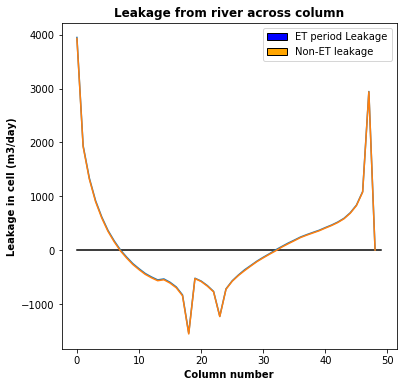

In [115]:
leak=leakage['sp%s'%(len(leakage)-2)][0]
tot_leak = sum(leak.q)
leak2=leakage['sp%s'%(len(leakage)-1)][0]
tot_leak2 = sum(leak2.q)
print(leak.q)
print(leak2.q)

x2 = []
for n in range(0,50):
    x2.append(n)
y2 = np.zeros(50)
fig = plt.figure(figsize=(6, 6))
x = list(range(49))
plt.plot(x2, y2, 'k')
plt.plot(x, leak.q)
plt.plot(x, leak2.q)
plt.plot()
plt.title('Leakage from river across column',fontweight='bold')
plt.xlabel('Column number', fontweight = 'bold')
plt.ylabel("Leakage in cell (m3/day)", fontweight = 'bold')
plt.legend(handles=[mp.patches.Patch(color='blue',label='ET period Leakage',ec='black'),
                   mp.patches.Patch(color='orange',label='Non-ET leakage',ec='black')])
                    
plt.show()

## Plot head at monitoring wells

In [116]:
#get time series for a certain cell

cell_id1 = (0,25,24) #cell ID of MW1
cell_id2 = (0,37,12) #cell ID of MW2
ag_id = (0,38,12)#cell ID of ag well
agua_id = (2,29,37) #Cell ID of aguaseca community well

time_series1 = headobj.get_ts(cell_id1) #get the time series at MW1
time_series2 = headobj.get_ts(cell_id2) #get the time series at MW2
time_series_ag = headobj.get_ts(ag_id) #get the time series at ag well
time_series_agua = headobj.get_ts(agua_id) #get the time series at agua seca com well
# print(time_series_ag)

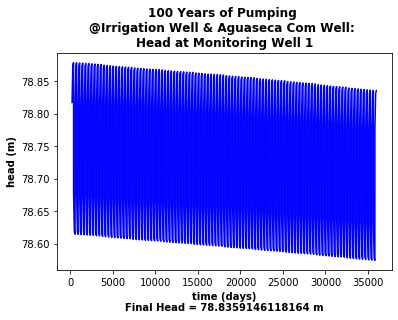

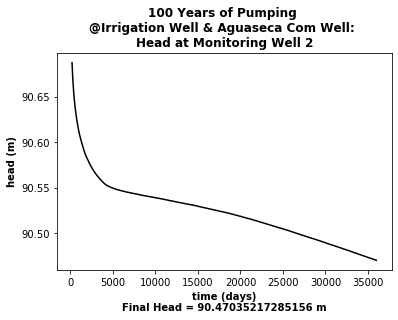

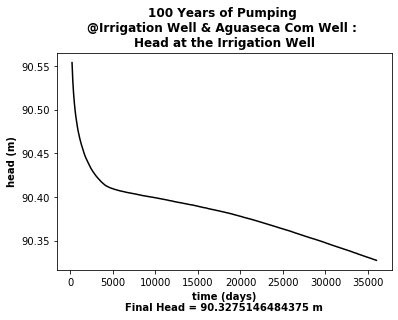

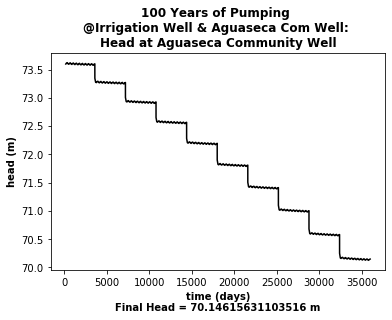

In [117]:

#create plot of MW1
plt.subplot(1, 1, 1)
ax=plt.gca()
ax.ticklabel_format(useOffset=False)
plt.title("100 Years of Pumping \n@Irrigation Well & Aguaseca Com Well: \nHead at Monitoring Well 1"
          ,fontweight='bold')
plt.xlabel('time (days)\n'f"Final Head = {head['sp%s'%(len(head)-1)][0, 25, 24]} m",fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
plt.plot(time_series1[:, 0], time_series1[:, 1], 'b-') #plot the time series with points at each record
plt.savefig("Head_M1_S5.png",dpi=600,bbox_inches='tight')
plt.show()

#create plot of MW2
plt.subplot(1, 1, 1)
ax=plt.gca()
ax.ticklabel_format(useOffset=False)
plt.title("100 Years of Pumping \n@Irrigation Well & Aguaseca Com Well: \nHead at Monitoring Well 2"
          ,fontweight='bold')
plt.xlabel('time (days)\n'f"Final Head = {head['sp%s'%(len(head)-1)][0, 37, 12]} m",fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
plt.plot(time_series2[:, 0], time_series2[:, 1], 'k-') #plot the time series with points at each record
plt.savefig("Head_M2_S5.png",dpi=600,bbox_inches='tight')
plt.show()

#create plot of Ag well
plt.subplot(1, 1, 1)
ax=plt.gca()
ax.ticklabel_format(useOffset=False)
plt.title("100 Years of Pumping \n@Irrigation Well & Aguaseca Com Well : \nHead at the Irrigation Well"
          ,fontweight='bold')
plt.xlabel('time (days)\n'f"Final Head = {head['sp%s'%(len(head)-1)][0,38,12]} m",fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
plt.plot(time_series_ag[:, 0], time_series_ag[:, 1], 'k-') #plot the time series with points at each record
plt.savefig("Head_Aq_S5.png",dpi=600,bbox_inches='tight')
plt.show()

#create plot of Aguaseca com well
plt.subplot(1, 1, 1)
ax=plt.gca()
ax.ticklabel_format(useOffset=False)
plt.title("100 Years of Pumping \n@Irrigation Well & Aguaseca Com Well: \nHead at Aguaseca Community Well"
          ,fontweight='bold')
plt.xlabel('time (days)\n'f"Final Head = {head['sp%s'%(len(head)-1)][2, 29, 37]} m",fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
plt.plot(time_series_agua[:, 0], time_series_agua[:, 1], 'k-') #plot the time series with points at each record
plt.savefig("Head_Aqua_S5.png",dpi=600,bbox_inches='tight')
plt.show()

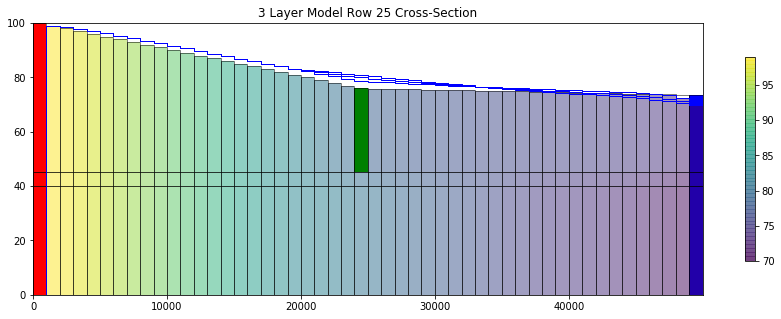

In [124]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=m, line={'row': 25}) #note use the key 'column' if you want to plot a column instaed
patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
headpc = head['sp%s'%(len(head)-1)]
pc = xsect.plot_array(headpc,masked_values=[-999.99], head=headpc, alpha=0.5)
patches = xsect.plot_bc('WEL', color='green')
linecollection = xsect.plot_grid(color='black', lw=0.5)
t = ax.set_title('3 Layer Model Row 25 Cross-Section')
cb = plt.colorbar(pc, shrink=0.75)

# Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head[0,:,:]
wt = xsect.plot_surface(head['sp%s'%(len(head)-1)], color='blue', lw=1)

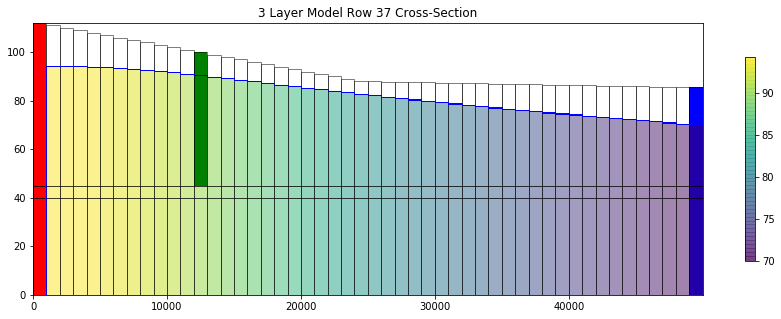

In [125]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=m, line={'row': 37}) #note use the key 'column' if you want to plot a column instaed
patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
headpc = head['sp%s'%(len(head)-1)]
pc = xsect.plot_array(headpc,masked_values=[-999.99], head=headpc, alpha=0.5)
patches = xsect.plot_bc('WEL', color='green')
linecollection = xsect.plot_grid(color='black', lw=0.5)
t = ax.set_title('3 Layer Model Row 37 Cross-Section')
cb = plt.colorbar(pc, shrink=0.75)

# Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head[0,:,:]
wt = xsect.plot_surface(head['sp%s'%(len(head)-1)], color='blue', lw=1)

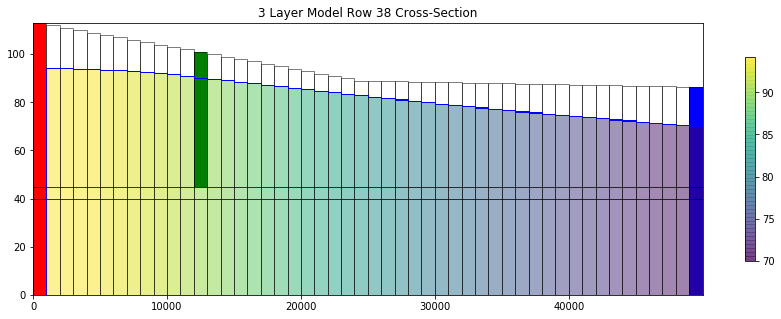

In [126]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=m, line={'row': 38}) #note use the key 'column' if you want to plot a column instaed
patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
headpc = head['sp%s'%(len(head)-1)]
pc = xsect.plot_array(headpc,masked_values=[-999.99], head=headpc, alpha=0.5)
patches = xsect.plot_bc('WEL', color='green')
linecollection = xsect.plot_grid(color='black', lw=0.5)
t = ax.set_title('3 Layer Model Row 38 Cross-Section')
cb = plt.colorbar(pc, shrink=0.75)

# Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head[0,:,:]
wt = xsect.plot_surface(head['sp%s'%(len(head)-1)], color='blue', lw=1)

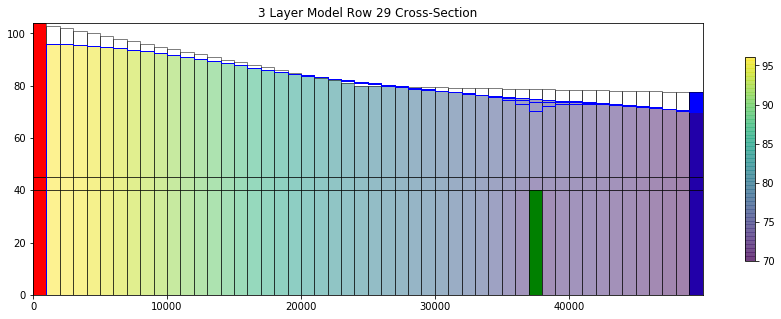

In [127]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=m, line={'row': 29}) #note use the key 'column' if you want to plot a column instaed
patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
headpc = head['sp%s'%(len(head)-1)]
pc = xsect.plot_array(headpc,masked_values=[-999.99], head=headpc, alpha=0.5)
patches = xsect.plot_bc('WEL', color='green')
linecollection = xsect.plot_grid(color='black', lw=0.5)
t = ax.set_title('3 Layer Model Row 29 Cross-Section')
cb = plt.colorbar(pc, shrink=0.75)

# Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head[0,:,:]
wt = xsect.plot_surface(head['sp%s'%(len(head)-1)], color='blue', lw=1)

## Saving final head array to start init heads in scen4

In [128]:
#Getting final heads
print("Final Head at Monitoring Well 1 = ", head['sp%s'%(len(head)-1)][0, 25, 24],'m')
print("Final Head at Monitoring Well 2 = ", head['sp%s'%(len(head)-1)][0, 37, 12],'m')
print("Final Head at Irrigation Well  = ", head['sp%s'%(len(head)-1)][0, 38, 12],'m')
print("Final Head at Aguaseca Community Well = ", head['sp%s'%(len(head)-1)][2, 29, 37],'m')

Final Head at Monitoring Well 1 =  78.835915 m
Final Head at Monitoring Well 2 =  90.47035 m
Final Head at Irrigation Well  =  90.327515 m
Final Head at Aguaseca Community Well =  70.14616 m


Final Head at Monitoring Well 1 =  78.835915 m
Final Head at Monitoring Well 2 =  90.47035 m
Final Head at Irrigation Well  =  90.327515 m
Final Head at Aguaseca Community Well =  70.14662 m

In [129]:
# head_top = head['sp%s'%(len(head)-1)][0,:,:]
# head_mid = head['sp%s'%(len(head)-1)][1,:,:]
# head_bot = head['sp%s'%(len(head)-1)][2,:,:]

# savetxt('top_head_postdevel_200yr_w_ag.csv', head_top, delimiter=',')
# savetxt('mid_head_postdevel_200yr_w_ag.csv', head_mid, delimiter=',')
# savetxt('bot_head_postdevel_200yr_w_ag.csv', head_bot, delimiter=',')

## ModPath

In [138]:
# moddirmp="C:\WRDAPP\modpath_7_2_001\mpath7"
moddirmp="/Users/hardknox47/Desktop/HWRS482/MODFLOW/pymake/examples/mp7"

mpname=os.path.join(modelname + '_mp')

locsb = [[0,28,18, 0,29,19]]

# set the number of particles per cell
sd = flopy.modpath.CellDataType(drape=0, columncelldivisions=2, rowcelldivisions=2, layercelldivisions=1)

# setup theparticles
p = flopy.modpath.LRCParticleData(subdivisiondata=[sd], lrcregions=[locsb])
pg2 = flopy.modpath.ParticleGroupLRCTemplate(particlegroupname='PG1',particledata=p,filename='ex01a.pg1.sloc')
particlegroups = [pg2]

defaultiface = {'RECHARGE': 6, 'ET': 6}

#setup  the modpath packages
mp = flopy.modpath.Modpath7(modelname=modelname + '_mp', flowmodel=m, exe_name=moddirmp)
mpbas = flopy.modpath.Modpath7Bas(mp, porosity=n, defaultiface=defaultiface)
mpsim = flopy.modpath.Modpath7Sim(mp, simulationtype='combined',
                                  trackingdirection='forward',
                                  weaksinkoption='stop_at',
                                  weaksourceoption='stop_at',
                                  budgetoutputoption='summary',
                                  stoptimeoption='extend', 
                                  particlegroups= particlegroups)

mp.add_package(rch)

# write modpath datasets
mp.write_input()

# run modpath
mp.run_model()

mp.get_package_list()

FloPy is using the following  executable to run the model: /Users/hardknox47/Desktop/HWRS482/MODFLOW/pymake/examples/mp7

MODPATH Version 7.2.001   
Program compiled Apr 22 2020 09:57:57 with GFORTRAN compiler (ver. 8.2.0)       


Program received signal SIGSEGV: Segmentation fault - invalid memory reference.

Backtrace for this error:
#0  0x103e1f9ac
#1  0x103e1ed53
#2  0x7fff722a85fc
#3  0x103de4bed
#4  0x103de978a
#5  0x103dedba8


['MPBAS', 'MPSIM', 'RCH']

In [ ]:
# load in the flow path file
fpth = os.path.join(mpname + '.mppth')
p = flopy.utils.PathlineFile(fpth)

# load in the end point file
fpth = os.path.join(mpname + '.mpend')
e = flopy.utils.EndpointFile(fpth, verbose=False)

# make a subset which is all the particles
pall = p.get_alldata()  # formerly pwb and ewb
eall = e.get_alldata()

# make a subset which is the partlces that end in the well 
rivernodes = list(range(1201, 1250))

# print(rivernodes)
priver = p.get_destination_pathline_data(dest_cells=rivernodes)
eriver= e.get_destination_endpoint_data(dest_cells=rivernodes)

In [ ]:
fig = plt.figure(figsize=(10, 10))
modelmap = flopy.plot.PlotMapView(model=m, layer=0)
grid = modelmap.plot_grid()
ib = modelmap.plot_ibound()

modelmap.plot_pathline(pall, layer='all', color='blue', lw=0.5, linestyle=':', label=' not captured by stream') #,marker='o', markercolor='black', markersize=3, markerevery=5)
modelmap.plot_pathline(priver, layer='all', color='green', lw=0.5, linestyle=':', label='captured by stream') # ,marker='o', markercolor='black', markersize=3, markerevery=5)
modelmap.ax.legend(loc='lower left', bbox_to_anchor=(1, 0.00),fontsize=13);
plt.title('Water captured by the stream',fontweight='bold',fontsize=13)
plt.show(modelmap)